In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

## Design Idea

In [2]:
span = 2540
offset = -25
slice_heigth = 161

(2857, 3058, 3)


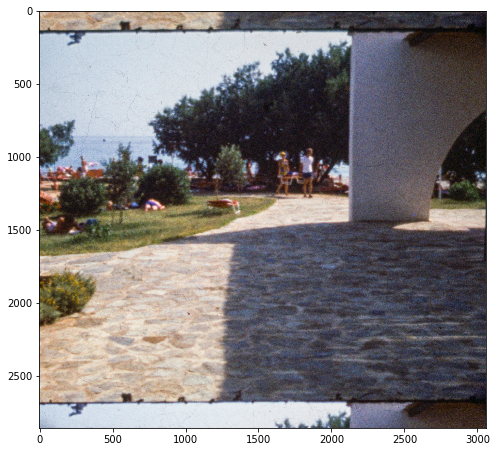

In [3]:
imgpath = "/Users/jankaiser/Desktop/stab_test/frame-00702.jpg"
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(8,8))
plt.imshow(img, interpolation="none")
plt.show()

In [4]:
def extract_sample(frame, span=2540, offset=-25, slice_heigth=161):
    bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    normed = bw / 255
    
    middle = normed.shape[0] / 2
    upper = middle + offset - span / 2
    lower = middle + offset + span / 2

    upper_slice = normed[int(upper-slice_heigth/2):int(upper+slice_heigth/2),:]
    lower_slice = normed[int(lower-slice_heigth/2):int(lower+slice_heigth/2),:]

    upper_squashed = cv2.resize(upper_slice, (161,161))
    lower_squashed = cv2.resize(lower_slice, (161,161))

    sample = np.stack([upper_squashed,lower_squashed])
    sample = np.moveaxis(sample, 0, -1)
    return sample

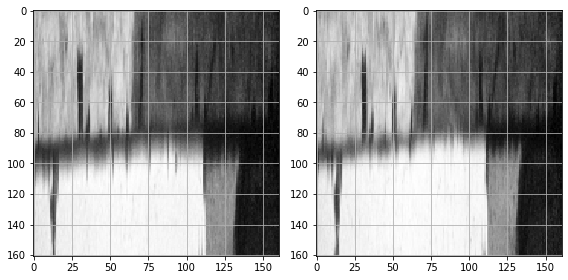

In [5]:
sample = extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sample[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

## Create Training Data

(1335, 2000, 3)


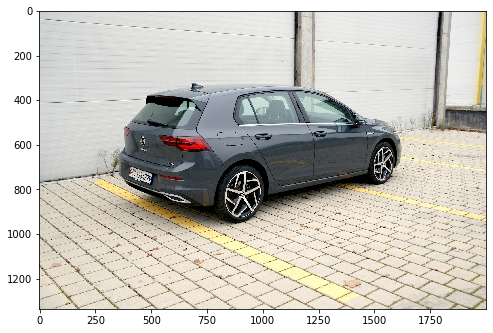

In [6]:
train_img = cv2.imread("/Users/jankaiser/Downloads/@Test-VW-Golf-8-4.jpeg", cv2.IMREAD_COLOR)
# train_img = cv2.imread("/Users/jankaiser/Downloads/gettyimages-632497192-2000.jpg", cv2.IMREAD_COLOR)
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

print(train_img.shape)

plt.figure(figsize=(8,8))
plt.imshow(train_img, interpolation="none")
plt.show()

In [7]:
def resize_to_fill(img, new_size):
    old_ar = img.shape[1] / img.shape[0]
    new_ar = new_size[1] / new_size[0]

    if old_ar > new_ar:
        crop_width = int(img.shape[0] * new_ar)
        cutoff = int((img.shape[1] - crop_width) / 2)
        cropped = img[:,cutoff:-cutoff]
    else:
        crop_height = int(img.shape[1] / new_ar)
        cutoff = int((img.shape[0] - crop_height) / 2)
        cropped = img[cutoff:-cutoff,:]
        
    resized = cv2.resize(cropped, (new_size[1],new_size[0]))
    return resized

(2540, 3058, 3)


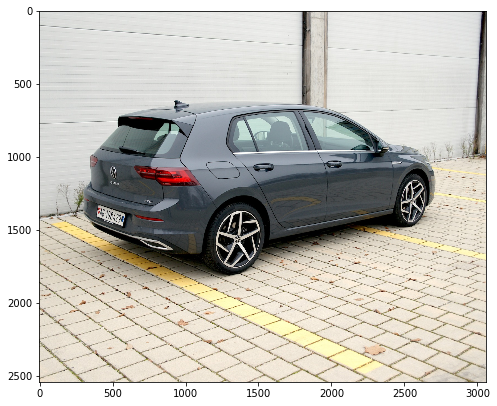

In [8]:
resized = resize_to_fill(train_img, (span,img.shape[1]))
print(resized.shape)

plt.figure(figsize=(8,8))
plt.imshow(resized, interpolation="none")
plt.show()

In [9]:
def draw_frame(img, sample_shape, offset, wabble, du, dl):
    ypos = int((sample_shape[0] - img.shape[0]) / 2 + offset + wabble)

    sample = np.zeros(sample_shape, dtype="uint8")
    sample[ypos:ypos+img.shape[0]] = img

    uypos = ypos - img.shape[0] - int(du)
    uheight = uypos + img.shape[0]
    sample[0:uheight] = img[-uheight:]

    lypos = ypos + img.shape[0] + int(dl)
    lheight = sample.shape[0] - lypos
    sample[-lheight:] = img[:lheight]

    return sample

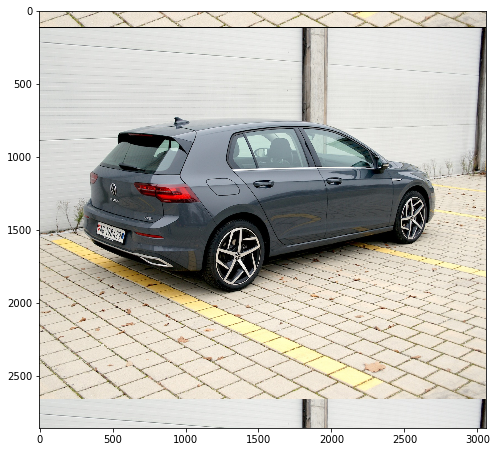

In [10]:
frame = draw_frame(
    resized,
    img.shape,
    offset,
    wabble=np.random.uniform(-40,40),
    du=np.random.uniform(0,20),
    dl=np.random.uniform(0,20)
)

plt.figure(figsize=(8,8))
plt.imshow(frame, interpolation="none")
plt.show()

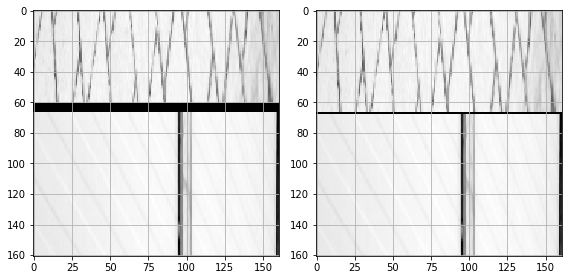

In [11]:
sample = extract_sample(frame, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sample[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
def create_train_sample(imgpath, span, offset, slice_heigth, max_wabble, max_d):
    wabble = np.random.uniform(-max_wabble,max_wabble)

    bgr = cv2.imread(imgpath, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    resized = resize_to_fill(rgb, (span,img.shape[1]))
    frame = draw_frame(
        resized,
        img.shape,
        offset,
        wabble=wabble,
        du=np.random.uniform(0,max_d),
        dl=np.random.uniform(0,max_d)
    )

    sample = extract_sample(frame, span=span, offset=offset, slice_heigth=slice_heigth)

    return sample, wabble

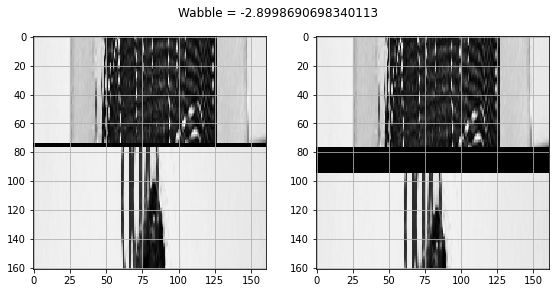

In [13]:
sample = create_train_sample(
    "/Users/jankaiser/Downloads/gettyimages-632497192-2000.jpg",
    span=span,
    offset=offset,
    slice_heigth=slice_heigth,
    max_wabble=40,
    max_d=20
)

plt.figure(figsize=(8,4))
plt.suptitle(f"Wabble = {sample[1]}")
plt.subplot(121)
plt.imshow(sample[0][:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[0][:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

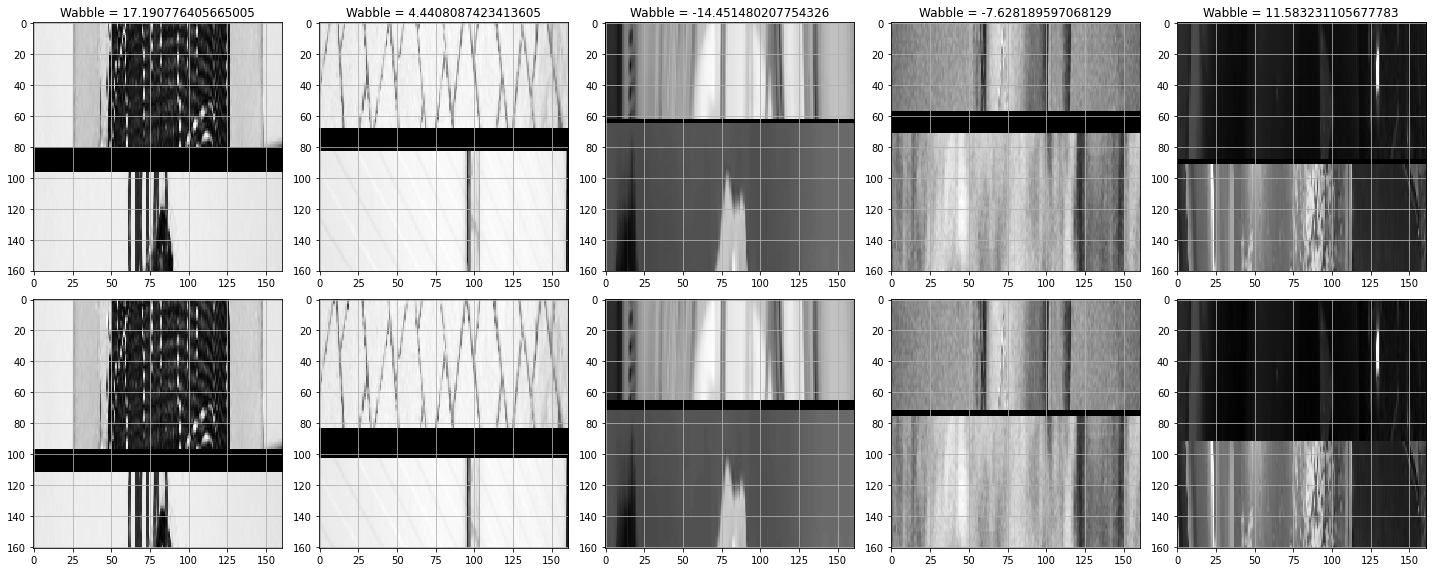

In [14]:
imgpaths = [
    "/Users/jankaiser/Downloads/gettyimages-632497192-2000.jpg",
    "/Users/jankaiser/Downloads/@Test-VW-Golf-8-4.jpeg",
    "/Users/jankaiser/Downloads/Screenshot 2021-10-29 at 15.38.59.png",
    "/Users/jankaiser/Downloads/19321040610_920395f4aa_o.jpg",
    "/Users/jankaiser/Downloads/maxresdefault.jpg"
]
samples = [create_train_sample(
    imgpath,
    span=span,
    offset=offset,
    slice_heigth=slice_heigth,
    max_wabble=40,
    max_d=20
) for imgpath in imgpaths]

plt.figure(figsize=(20,8))
for i, sample in enumerate(samples):
    plt.subplot(2, 5, i+1)
    plt.title(f"Wabble = {sample[1]}")
    plt.imshow(sample[0][:,:,0], cmap="gray", interpolation="none")
    plt.grid()
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(sample[0][:,:,1], cmap="gray", interpolation="none")
    plt.grid()
plt.tight_layout()
plt.show()

## Train

In [15]:
X = np.array([sample[0] for sample in samples])
y = np.array([sample[1] for sample in samples])
X.shape

(5, 161, 161, 2)

In [16]:
model = keras.Sequential([
    Conv2D(16, (5,25), strides=(1,7), activation="relu", input_shape=(161,161,2)),
    Conv2D(8, (3,15), strides=(1,1), activation="relu"),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
])
model.summary()

2021-11-14 19:37:35.631204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 157, 20, 16)       4016      
                                                                 
 conv2d_1 (Conv2D)           (None, 155, 6, 8)         5768      
                                                                 
 flatten (Flatten)           (None, 7440)              0         
                                                                 
 dense (Dense)               (None, 32)                238112    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 247,929
Trainable params: 247,929
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(X[:-1], y[:-1], epochs=100, shuffle=True, validation_data=(X[-1:],y[-1:]))

Epoch 1/100
1/1 [==============================] - 1s 731ms/step - loss: 145.1968 - mae: 10.9216 - val_loss: 132.2043 - val_mae: 11.4980
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 139.0722 - mae: 10.7026 - val_loss: 125.7133 - val_mae: 11.2122
Epoch 3/100
1/1 [==============================] - 0s 86ms/step - loss: 121.5741 - mae: 10.1131 - val_loss: 119.9588 - val_mae: 10.9526
Epoch 4/100
1/1 [==============================] - 0s 93ms/step - loss: 97.0678 - mae: 9.1971 - val_loss: 84.7507 - val_mae: 9.2060
Epoch 5/100
1/1 [==============================] - 0s 70ms/step - loss: 60.6914 - mae: 7.4071 - val_loss: 43.2296 - val_mae: 6.5749
Epoch 6/100
1/1 [==============================] - 0s 107ms/step - loss: 26.3090 - mae: 4.6504 - val_loss: 31.1671 - val_mae: 5.5828
Epoch 7/100
1/1 [==============================] - 0s 95ms/step - loss: 15.8070 - mae: 2.3074 - val_loss: 0.5689 - val_mae: 0.7543
Epoch 8/100
1/1 [==============================] - 0s 144ms/ste

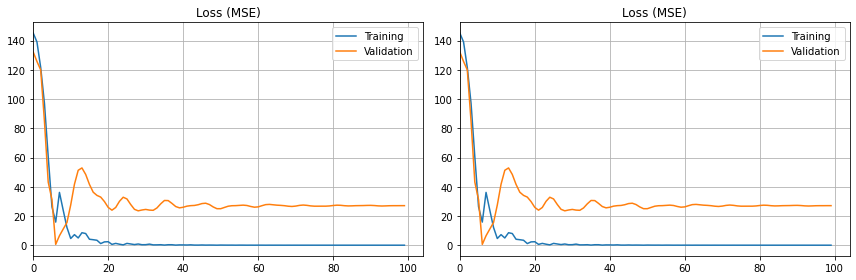

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlim(0, None)
plt.grid()
plt.legend()
plt.subplot(122)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlim(0, None)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Generate Stabilised Video